# Setting up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# model_path = "/content/drive/MyDrive/ACES_COMET_baseline/wmt22-comet-da/checkpoints/model.ckpt"
model_path = "/content/drive/MyDrive/ACES_COMET_baseline/COMET/wmt22-unite-da/checkpoints/model.ckpt"
WMT_data_path = "/content/drive/MyDrive/ACES_COMET_baseline/data/WMT_data/ende-2021-concat.csv"
output_path = "/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs"
# output_path = "/content/drive/MyDrive/ACES_UNITE_baseline/UNITE_outputs"

In [ ]:
! pip install --upgrade pip
! pip install git+https://github.com/Unbabel/COMET.git@explainable-metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Cloning https://github.com/Unbabel/COMET.git (to revision explainable-metrics) to /tmp/pip-req-build-9q0ey46g
  Running command git clone --filter=blob:none --quiet https://github.com/Unbabel/COMET.git /tmp/pip-req-build-9q0ey46g
  Running command git checkout -b explainable-metrics --track origin/explainable-metrics
  Switched to a new branch 'explainable-metrics'
  Branch 'explainable-metrics' set up to track remote branch 'explainable-metrics' from 'origin'.
  Resolved https://github.com/Unbabel/COMET.git to commit 770c2900c93ad6ed30bd43227531325e76d9b019
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 4.6 MB/s eta 0:

In [ ]:
%cd /content/drive/MyDrive/ACES_COMET_baseline

/content/drive/MyDrive/ACES_COMET_baseline


In [ ]:
! git clone --single-branch --branch explainable-metrics https://github.com/Unbabel/COMET.git

fatal: destination path 'COMET' already exists and is not an empty directory.


In [ ]:
! pip install huggingface_hub
! pip install pytorch_lightning
! pip install transformers
! pip install entmax

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# clone the model repo in https://huggingface.co/Unbabel/wmt22-comet-da
! git lfs install
# ! git clone https://huggingface.co/Unbabel/wmt22-comet-da
! git clone https://huggingface.co/Unbabel/wmt22-unite-da

Updated git hooks.
Git LFS initialized.
Cloning into 'wmt22-unite-da'...
remote: Enumerating objects: 19, done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 19
Unpacking objects: 100% (19/19), 4.16 KiB | 24.00 KiB/s, done.
fatal: cannot exec '/content/drive/MyDrive/ACES_COMET_baseline/COMET/wmt22-unite-da/.git/hooks/post-checkout': Permission denied


In [ ]:
%cd COMET

/content/drive/MyDrive/ACES_COMET_baseline/COMET


# COMET

## COMET: Save Embedding Alignment Scores Between Incorrect and Src, Ref, Src+ref

In [ ]:
model_path = "/content/drive/MyDrive/ACES_COMET_baseline/wmt22-comet-da/checkpoints/model.ckpt"
WMT_data_path = "/content/drive/MyDrive/ACES_COMET_baseline/data/WMT_data/ende-2021-concat.csv"
output_path = "/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs"

In [ ]:
! python explainable-metrics/save_comet_alignments.py -m {model_path} -t {WMT_data_path} --batch_size 8 -o {output_path}

## Span Predictions: Find a Threshold Using ende-2021-concat as a Dev set

In [ ]:
# load the scores
import os, json
import numpy as np
out_path = "/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs"
scores = {}
with open(os.path.join(out_path, "ref_scores.json"), "r") as f:
    ref_scores = json.load(f)
with open(os.path.join(out_path, "src_scores.json"), "r") as f:
    src_scores = json.load(f)
with open(os.path.join(out_path, "mt_scores.json"), "r") as f:
    mt_scores = json.load(f)
with open(os.path.join(out_path, "src_ref_scores.json"), "r") as f:
    src_ref_scores = json.load(f)

In [ ]:
from comet import download_model, load_from_checkpoint
model = load_from_checkpoint(model_path)
model.encoder.add_span_tokens("<v>", "</v>")
print(model.encoder.tokenizer.encode("<v>"), model.encoder.tokenizer.encode("</v>"))
# 0: start of doc, 2:end of doc

[0, 250002, 2] [0, 250003, 2]


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [ ]:
gold_span_masks = src_scores["in_span_mask"]
input_ids = src_scores["input_ids"]

In [ ]:
# we show in all of them in_span_masks are the same: it is the gold truth span mask annotated in the MT.
# we are not interested in this becuase we need the gold truth spans fro evaluation or training, not for predicting spans.
# we only need the in_span_masks to filter out the padding, so put them in one list
for i in range(len(src_scores["in_span_mask"])):
  if not src_scores["in_span_mask"][i] == ref_scores["in_span_mask"][i] == src_ref_scores["in_span_mask"][i] == mt_scores["in_span_mask"][i]:
    print(i)

In [ ]:
# we show in all of them input_ids are the same: it is the input_ids in the MT. Collect all to one list: input_ids
for i in range(len(src_scores["input_ids"])):
  if not src_scores["input_ids"][i] == ref_scores["input_ids"][i] == src_ref_scores["input_ids"][i] == mt_scores["input_ids"][i]:
    print(i)

In [ ]:
# what is attention_mask that only the MT has?
# I think it only shows exactly the paddings: so -1s in the in_span_mask
# so not important
mt_scores["attention_mask"][0]

In [ ]:
# we show in all of them input_ids are the same: it is the input_ids in the MT. Collect all to one list: input_ids
for i in range(len(src_scores["input_ids"])):
  if not src_scores["input_ids"][i] == ref_scores["input_ids"][i] == src_ref_scores["input_ids"][i] == mt_scores["input_ids"][i]:
    print(i)

In [ ]:
import matplotlib.pyplot as plt

def add_span_tokens(binary_mask, integer_array, start_token, end_token):
    modified_integer_array = []

    # Handle the case when binary_mask starts with 1
    if binary_mask[0] == 1:
        modified_integer_array.append(start_token)
        modified_integer_array.append(integer_array[0])
    else:
        modified_integer_array.append(integer_array[0])

    for i in range(1, len(binary_mask)):
        if binary_mask[i] != binary_mask[i - 1]:
            if binary_mask[i] == 1:  # Change from 0 to 1
                modified_integer_array.append(start_token)
            else:  # Change from 1 to 0
                modified_integer_array.append(end_token)
            modified_integer_array.append(integer_array[i])
        else:
            modified_integer_array.append(integer_array[i])

    # Handle the case when binary_mask ends with 1
    if binary_mask[-1] == 1:
        modified_integer_array.append(end_token)
    else:
        modified_integer_array.append(integer_array[-1])

    return modified_integer_array

def plot(f1_scores, thresholds, title="F1 Scores"):
    src = f1_scores[0]
    ref = f1_scores[1]
    src_ref = f1_scores[2]
    plt.plot(thresholds, src, '-o', label='src')
    plt.plot(thresholds, ref, '-s', label='ref')
    plt.plot(thresholds, src_ref, '-^', label='src_ref')
    plt.xlabel('Thresholds')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# ----------------------------- THE EXPERIMENTS FOR EVALUATING SPANS -----------------------------
import re

def span_f1(prediction, ground_truth):
    pattern = r'<v>(.*?)</v>'

    predicted_spans = re.findall(pattern, prediction)
    ground_truth_spans = re.findall(pattern, ground_truth)

    tp = len(set(predicted_spans) & set(ground_truth_spans))
    fp = len(set(predicted_spans) - set(ground_truth_spans))
    fn = len(set(ground_truth_spans) - set(predicted_spans))
    # calculate precision, recall and f1
    if tp == 0 and fp == 0 and fn == 0:
        # Both ground truth and prediction sets are empty
        f1 = 1.0
    else:
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return f1

def span_hit_indicator(sentence, error_spans):
    pattern = r'<v>(.*?)</v>'
    predicted_spans = re.findall(pattern, sentence)
    hits = [0 for i in range(len(predicted_spans))]
    for k, span in enumerate(predicted_spans):
        span_tokens = span.split() #use a tokenizer here
        for error in error_spans:
            error_tokens = error.split() #use a tokenizer here
            #get a list of common tokens
            common_tokens = list(set(span_tokens) & set(error_tokens))
            if len(common_tokens)!=0:
                hits[k] = 1
                break
    return hits

def calculate_jaccard_index(span1, span2):
    # Calculate the Jaccard Index for two spans
    intersection = len(set(span1).intersection(span2))
    union = len(set(span1).union(span2))
    jaccard_index = intersection / union if union > 0 else 0
    return jaccard_index

def calculate_tp_fp_fn(predictions, ground_truth, jaccard_threshold=0.5):
    tp, fp, fn = 0, 0, 0

    for prediction_span in predictions:
        is_tp = False

        for truth_span in ground_truth:
            jaccard_index = calculate_jaccard_index(prediction_span, truth_span)

            if jaccard_index >= jaccard_threshold:
                is_tp = True
                break

        if is_tp:
            tp += 1
        else:
            fp += 1

    for truth_span in ground_truth:
        is_fn = True

        for prediction_span in predictions:
            jaccard_index = calculate_jaccard_index(prediction_span, truth_span)

            if jaccard_index >= jaccard_threshold:
                is_fn = False
                break

        if is_fn:
            fn += 1

    return tp, fp, fn

def sentence_to_binary_list(sentence):
    sentence = re.sub("<v>", "{", sentence)
    sentence = re.sub("</v>", "}", sentence)
    # Initialize an empty list to store binary values
    binary_list = []
    # Initialize a variable to keep track of whether we're inside a span
    in_span = False
    for char in sentence:
        if char == '{':
            in_span = True
        elif char == '}':
            in_span = False
        else:
            binary_list.append(in_span)
    return np.array(binary_list)

# for efficiency, give ground_truths as already binary arrays
def calculate_tp_fp_fn_custom(prediction, ground_truth):
    prediction = sentence_to_binary_list("".join(prediction.split()))
    # ground_truth = sentence_to_binary_list(ground_truth)
    tp = np.sum(prediction & ground_truth)  # True positives
    fp = np.sum(prediction & ~ground_truth)  # False positives
    fn = np.sum(~prediction & ground_truth)
    return tp, fp, fn

# -------------------------------------- OVER THE WHOLE SET ----------------------------------------------------
#Note that the two functions below operate on a corpus level than example level
def hypothesis_span_hit(predictions, ground_truths, skip_empty=False, skip_whole_sentence=False):
    hits = []
    pattern = r'<v>(.*?)</v>'
    for i in range(len(predictions)):
        sentence = predictions[i]
        error_spans = re.findall(pattern, ground_truths[i])
        if (not skip_empty or len(error_spans) > 0) and (not skip_whole_sentence or not (ground_truths[i].startswith("<v>") and ground_truths[i].endswith("</v>"))):
            hits = hits + span_hit_indicator(sentence, error_spans)

    return np.sum(hits)/len(hits)


def target_span_hit(predictions, ground_truths, skip_empty=False, skip_whole_sentence=False):
    hits = []
    pattern = r'<v>(.*?)</v>'
    for i in range(len(predictions)):
        sentence = ground_truths[i]
        error_spans = re.findall(pattern, predictions[i])
        if not skip_empty or len(re.findall(pattern, sentence)) > 0 and (not skip_whole_sentence or not (sentence.startswith("<v>") and sentence.endswith("</v>"))):
            hits = hits + span_hit_indicator(sentence, error_spans)
    return np.sum(hits)/len(hits)


def f1_hit(target_hit, hypothesis_hit):
    """
    # target hit is precision and hypothesis_hit is recall
    if tp == 0 and fp == 0 and fn == 0:
        # Both ground truth and prediction sets are empty
        f1 = 1.0
    else:
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    """
    return 2*target_hit*hypothesis_hit/(target_hit+hypothesis_hit) if target_hit + hypothesis_hit > 0 else 0

def avg_flexible_span_f1(predictions, ground_truths, skip_empty=False):
    return f1_hit(target_span_hit(predictions, ground_truths, skip_empty=False), hypothesis_span_hit(predictions, ground_truths, skip_empty=False))

def avg_jaccard_span_f1(predictions, ground_truths, skip_empty=False, skip_whole_sentence=False, jaccard_threshold=0.5):
    scores = []
    pattern = r'<v>(.*?)</v>'
    for i in range(len(predictions)):
        pred_spans = re.findall(pattern, predictions[i])
        gold_spans = re.findall(pattern, ground_truths[i])
        tp, fp, fn = calculate_tp_fp_fn(pred_spans, gold_spans, jaccard_threshold)
        # calculate precision, recall and f1
        if tp == 0 and fp == 0 and fn == 0:
            # Both ground truth and prediction sets are empty
            f1 = 1.0
        else:
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        if (not skip_empty or len(gold_spans) > 0) and (not skip_whole_sentence or not (ground_truths[i].startswith("<v>") and ground_truths[i].endswith("</v>"))):
          scores.append(f1)
    return np.average(scores)

def avg_span_f1(predictions, ground_truths, skip_one=False):
    f1_scores = np.array([span_f1(predictions[i], ground_truths[i]) for i in range(len(predictions))])
    return np.average(f1_scores[f1_scores<1])

# for efficiency, give ground_truths as already binary arrays
def avg_char_lvl_span_f1(predictions, ground_truths, skip_one=False):
    scores = []
    for i in range(len(predictions)):
        tp, fp, fn = calculate_tp_fp_fn_custom(predictions[i], ground_truths[i])
        # calculate precision, recall and f1
        if tp == 0 and fp == 0 and fn == 0:
            # Both ground truth and prediction sets are empty
            f1 = 1.0
        else:
            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        if not(skip_one and tp == 0 and fp == 0 and fn == 0):
            scores.append(f1)
    return np.average(scores)

# for efficiency, give ground_truths as already binary arrays
def avg_char_lvl_span_acc(predictions, ground_truths, skip_empty=np.inf):
    scores = []
    empty_count = 0
    for i in range(len(predictions)):
        pred = sentence_to_binary_list("".join(predictions[i].split()))
        intersection = np.logical_and(pred, ground_truths[i])
        union = np.logical_or(pred, ground_truths[i])
        if empty_count <= skip_empty and np.sum(union)==0:
            scores.append(1.)
            empty_count += 1
        elif empty_count > skip_empty and np.sum(union)==0:
            pass
        else:
            scores.append(np.sum(intersection) / np.sum(union))

    return np.average(scores)

In [ ]:
# ----------------------------- THE CHOSEN METHOD FOR EVALUATING SPANS -----------------------------
# the chosen method: Recall but with both gold and predictions are tokenized to subword unit
def compute_compute_recall_topk(subword_scores):

    def recall_at_topk(model_scores, gold_score):
        idxs = np.argsort(model_scores)[::-1][:sum(gold_score)]
        return len([idx for idx in idxs if gold_score[idx] == 1])/sum(gold_score)

    res = []
    for i in range(len(subword_scores["in_span_mask"])):
        mt_length = (np.array(subword_scores["in_span_mask"][i]) != -1).sum()
        y_hat = subword_scores["subword_scores"][i][:mt_length]
        y = subword_scores["in_span_mask"][i][:mt_length]

        # check if annotation is missing
        if (np.array(y) == 1).sum() == 0:
            continue

        res.append(recall_at_topk(np.array(y_hat), np.array(y)))
    return sum(res)/len(res)

In [ ]:
from tqdm import tqdm

thresholds = np.arange(0., 0.3, 0.01)
# metric = avg_jaccard_span_f1
jaccard_threshold = 0.5
src_f1, ref_f1, src_ref_f1 = [], [], []
src_target_hit, ref_target_hit, src_ref_target_hit = [], [], []
src_hypothesis_hit, ref_hypothesis_hit, src_ref_hypothesis_hit = [], [], []

start_token = model.encoder.tokenizer.encode("<v>")[1]
end_token = model.encoder.tokenizer.encode("</v>")[1]


for threshold in tqdm(thresholds):
    gold_spans_input_ids = []
    src_spans_input_ids = []
    ref_spans_input_ids = []
    src_ref_spans_input_ids = []

    src_spans_scores_threshold = []
    ref_spans_scores_threshold = []
    src_ref_spans_scores_threshold = []

    # for all the samples, calculate the input ids of the sentences with the generated spans. also for the gold annotated sentneces
    for i in range(len(gold_span_masks)):
        # common in all
        padding_filter = np.array(gold_span_masks[i])!=-1
        input_ids_tmp = np.array(input_ids[i])[padding_filter]
        gold_spans_input_ids.append(add_span_tokens(np.array(gold_span_masks[i])[padding_filter], input_ids_tmp, start_token, end_token))

        # only src
        src_scores_tmp = np.array(src_scores["scores"][i])[padding_filter]
        src_span_masks = src_scores_tmp > threshold
        src_spans_input_ids.append(add_span_tokens(src_span_masks, input_ids_tmp, start_token, end_token))
        src_spans_scores_threshold.append(src_span_masks)

        # only ref
        ref_scores_tmp = np.array(ref_scores["scores"][i])[padding_filter]
        ref_span_masks = ref_scores_tmp > threshold
        ref_spans_input_ids.append(add_span_tokens(ref_span_masks, input_ids_tmp, start_token, end_token))
        ref_spans_scores_threshold.append(ref_span_masks)

        # only src-ref
        src_ref_scores_tmp = np.array(src_ref_scores["scores"][i])[padding_filter]
        src_ref_span_masks = src_ref_scores_tmp > threshold
        src_ref_spans_input_ids.append(add_span_tokens(src_ref_span_masks, input_ids_tmp, start_token, end_token))
        src_ref_spans_scores_threshold.append(src_ref_span_masks)

        """
        outs = model.encoder.tokenizer.batch_decode([
                                              input_ids[0],
                                              np.array(input_ids[i])[np.array(gold_span_masks[i])==1],
                                              np.array(input_ids[i])[np.array(src_scores["scores"][i])>threshold],
                                              np.array(input_ids[i])[np.array(ref_scores["scores"][i])>threshold],
                                              np.array(input_ids[i])[np.array(src_ref_scores["scores"][i])>threshold],
                                              ],
                                            skip_special_tokens=True)

        print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", outs[1], "\nSRC PRED:\t", outs[2], "\nREF PRED:\t", outs[3], "\nSRC-REF PRED:\t", outs[4])

        print("--------------------------- FULL SPANS ----------------------------------------------------------------")
        print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", gold_annotated, "\nSRC PRED:\t", src_annotated, "\nREF PRED:\t", ref_annotated, "\nSRC-REF PRED:\t", src_ref_annotated)
        """
    # decode to get the spans in string form
    all_spans_decoded = model.encoder.tokenizer.batch_decode(gold_spans_input_ids+src_spans_input_ids+ref_spans_input_ids+src_ref_spans_input_ids, skip_special_tokens=True)

    gold_spans = all_spans_decoded[:len(gold_spans_input_ids)]
    src_spans = all_spans_decoded[len(gold_spans_input_ids):2*len(gold_spans_input_ids)]
    ref_spans = all_spans_decoded[2*len(gold_spans_input_ids):3*len(gold_spans_input_ids)]
    src_ref_spans = all_spans_decoded[3*len(gold_spans_input_ids):4*len(gold_spans_input_ids)]

    # now for all 3 (src, ref, src_ref), calculate the avg F1 scores with given threshold
    """
    src_t, ref_t, src_ref_t = target_span_hit(src_spans, gold_spans, skip_empty=True, skip_whole_sentence=True), target_span_hit(ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True), target_span_hit(src_ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True)
    src_h, ref_h, src_ref_h = hypothesis_span_hit(src_spans, gold_spans, skip_empty=True, skip_whole_sentence=True), hypothesis_span_hit(ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True), hypothesis_span_hit(src_ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True)
    src_target_hit.append(src_t)
    ref_target_hit.append(ref_t)
    src_ref_target_hit.append(src_ref_t)
    src_hypothesis_hit.append(src_h)
    ref_hypothesis_hit.append(ref_h)
    src_ref_hypothesis_hit.append(src_ref_h)
    src_f1.append(f1_hit(src_t, src_h))
    ref_f1.append(f1_hit(ref_t, ref_h))
    src_ref_f1.append(f1_hit(src_ref_t, src_ref_h))

    ground_truths = [sentence_to_binary_list("".join(gold_span.split())) for gold_span in gold_spans]
    src_f1.append(metric(src_spans, gold_spans, skip_empty=True, skip_whole_sentence=True))
    ref_f1.append(metric(ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True))
    src_ref_f1.append(metric(src_ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True))
    """
    src_subword_dict = {
        "in_span_mask":gold_span_masks,
        "subword_scores":src_spans_scores_threshold
    }
    src_f1.append(compute_compute_recall_topk(src_subword_dict))
    ref_subword_dict = {
        "in_span_mask":gold_span_masks,
        "subword_scores":ref_spans_scores_threshold
    }
    ref_f1.append(compute_compute_recall_topk(ref_subword_dict))
    src_ref_subword_dict = {
        "in_span_mask":gold_span_masks,
        "subword_scores":src_ref_spans_scores_threshold
    }
    src_ref_f1.append(compute_compute_recall_topk(src_ref_subword_dict))

100%|██████████| 30/30 [14:36<00:00, 29.21s/it]


In [ ]:
# get all the scores without the padded tags
src_scores_sum, ref_scores_sum, src_ref_scores_sum = [], [], []
for i in range(len(gold_span_masks)):
    padding_filter = np.array(gold_span_masks[i])!=-1
    src_scores_sum.append(np.sum(np.array(src_scores["scores"][i])[padding_filter]))
    ref_scores_sum.append(np.sum(np.array(ref_scores["scores"][i])[padding_filter]))
    src_ref_scores_sum.append(np.sum(np.array(src_ref_scores["scores"][i])[padding_filter]))
print("Mean(sum(scores)) for src, ref, src_ref: ", np.average(src_scores_sum), np.average(ref_scores_sum), np.average(src_ref_scores_sum))

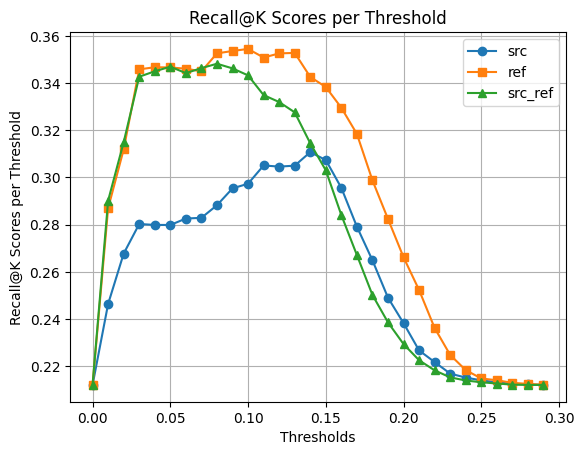

In [ ]:
# skip all sentences with no spans and whole sentence is span
plot([src_f1, ref_f1, src_ref_f1], thresholds, title="Recall@K Scores per Threshold")

In [ ]:
# THE CHSEN THRESHOLD
thresholds[np.argmax(ref_f1)]

### Some Results for finding Threshold -Using some span match metrics

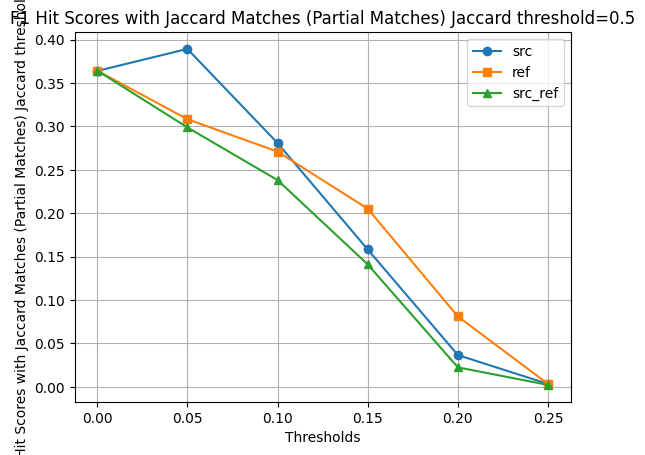

In [ ]:
# skip all sentences with no spans and whole sentence is span
plot([src_f1, ref_f1, src_ref_f1], thresholds, title="F1 Hit Scores with Jaccard Matches (Partial Matches) Jaccard threshold=0.5")

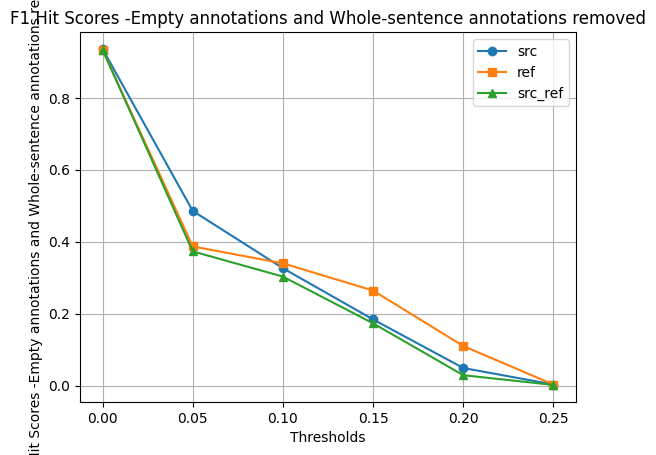

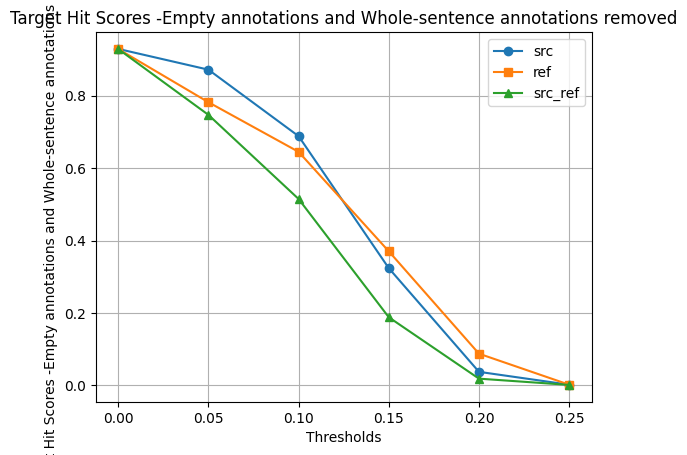

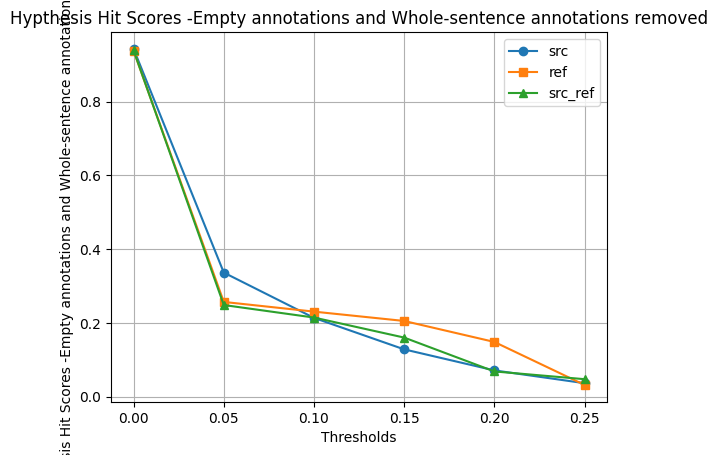

In [ ]:
plot([src_f1, ref_f1, src_ref_f1], thresholds, title="F1 Hit Scores -Empty annotations and Whole-sentence annotations removed")
plot([src_target_hit, ref_target_hit, src_ref_target_hit], thresholds, title="Target Hit Scores -Empty annotations and Whole-sentence annotations removed")
plot([src_hypothesis_hit, ref_hypothesis_hit, src_ref_hypothesis_hit], thresholds, title="Hypthesis Hit Scores -Empty annotations and Whole-sentence annotations removed")

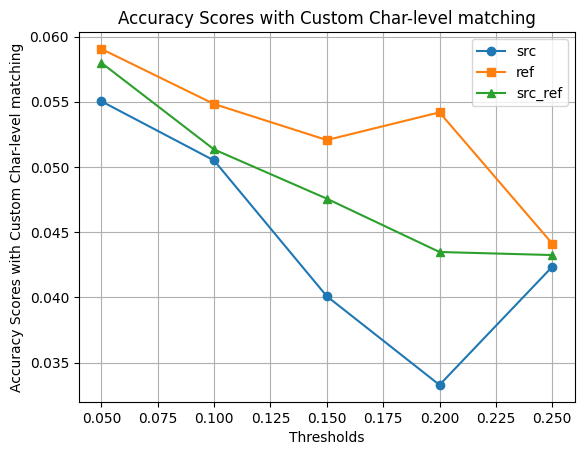

In [ ]:
# skip all sentences with no spans -allow 127
plot([src_f1, ref_f1, src_ref_f1], thresholds, title="Accuracy Scores with Custom Char-level matching")

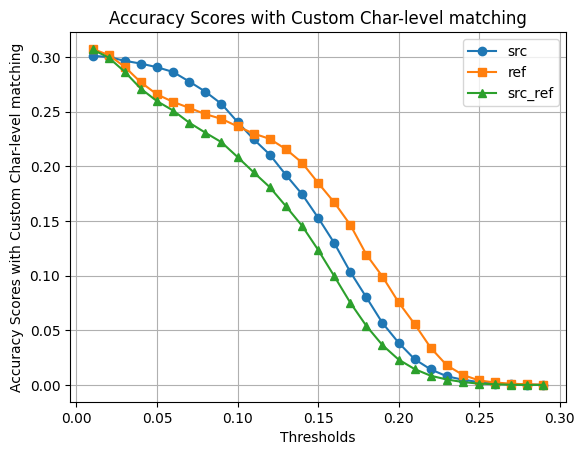

In [ ]:
# skip all sentences with no spans
plot([src_f1, ref_f1, src_ref_f1], thresholds, title="Accuracy Scores with Custom Char-level matching")

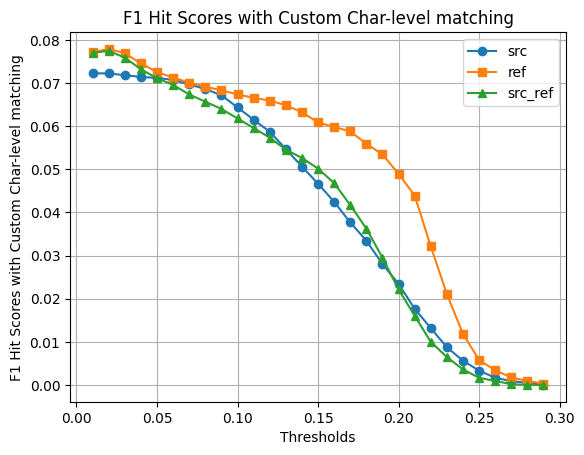

In [ ]:
# skip all sentences with no spans
plot([src_f1, ref_f1, src_ref_f1], thresholds, title="F1 Hit Scores with Custom Char-level matching")

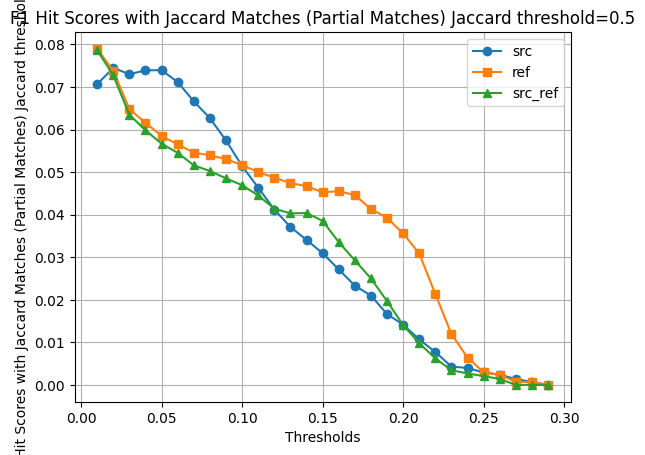

In [ ]:
# skip all sentences with no spans
plot([src_f1, ref_f1, src_ref_f1], thresholds, title="F1 Hit Scores with Jaccard Matches (Partial Matches) Jaccard threshold=0.5")

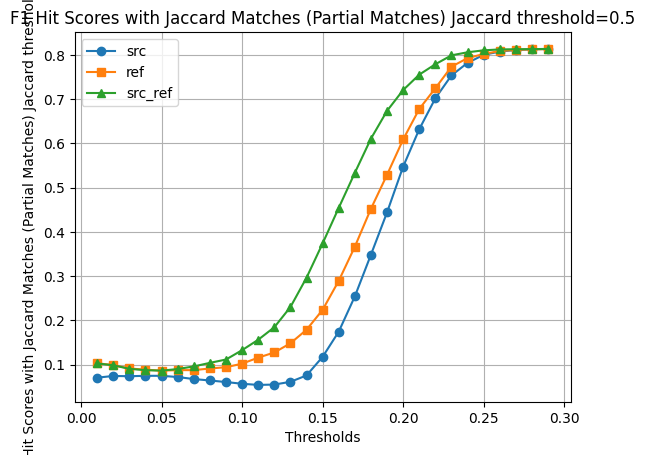

In [ ]:
# without skipping the empty spans (sentences with no spans)
plot([src_f1, ref_f1, src_ref_f1], thresholds, title="F1 Hit Scores with Jaccard Matches (Partial Matches) Jaccard threshold=0.5")

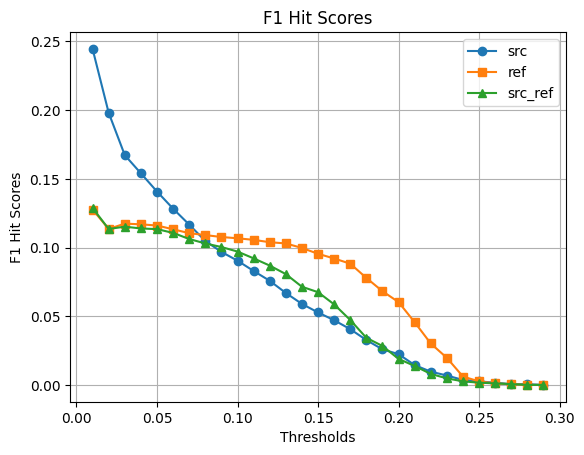

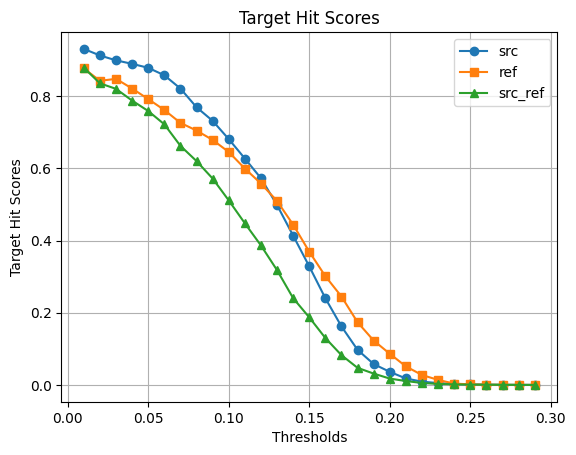

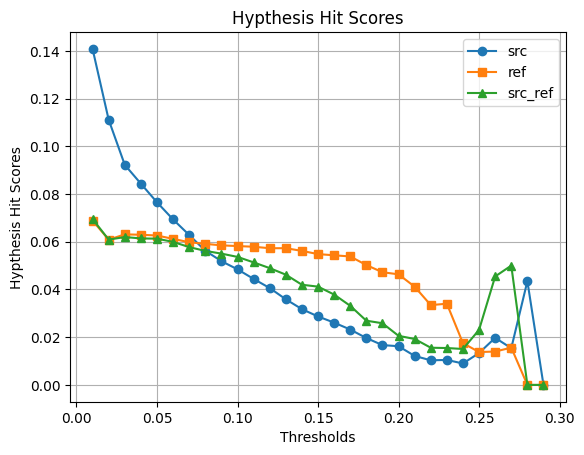

In [ ]:
plot([src_f1, ref_f1, src_ref_f1], thresholds, title="F1 Hit Scores")
plot([src_target_hit, ref_target_hit, src_ref_target_hit], thresholds, title="Target Hit Scores")
plot([src_hypothesis_hit, ref_hypothesis_hit, src_ref_hypothesis_hit], thresholds, title="Hypthesis Hit Scores")

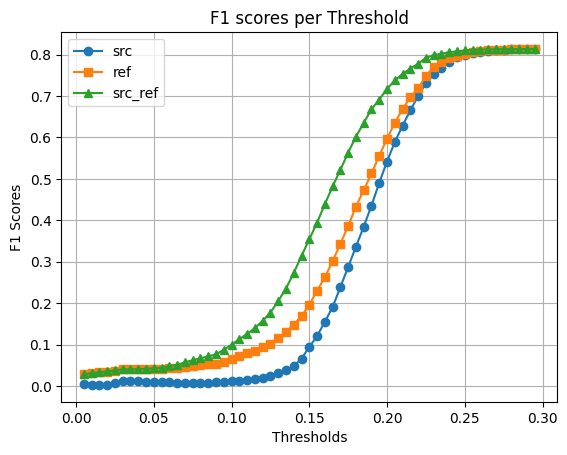

In [ ]:
# counting the samples without spans too. they are 80% so it reaches 0.8 F1 score
plot([src_f1, ref_f1, src_ref_f1], thresholds)

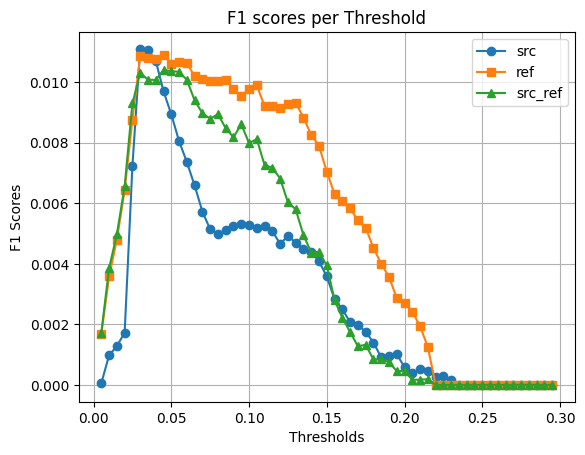

In [ ]:
# whitout counting the samples with no spans
plot([src_f1, ref_f1, src_ref_f1], thresholds)

## Load ACES in MQM format and save the Spans
Make sure to switch to GPUs and save these jsons:


1.   good_mt_scores.json
2.   good_src_scores.json
3.   ...
2.   incorrect_mt_scores.json





In [ ]:
model_path = "/content/drive/MyDrive/ACES_COMET_baseline/wmt22-comet-da/checkpoints/model.ckpt"
ACES_data_path_good = "/content/drive/MyDrive/ACES_COMET_baseline/data/ACES_final_merged_MQM_good.csv"
ACES_data_path_incorrect = "/content/drive/MyDrive/ACES_COMET_baseline/data/ACES_final_merged_MQM_incorrect.csv"
output_path_good = "/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs/on_ACES/good"
output_path_incorrect = "/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs/on_ACES/incorrect"

In [ ]:
! python explainable-metrics/save_comet_alignments.py -m {model_path} -t {ACES_data_path_good} --batch_size 8 -o {output_path_good}

In [ ]:
! python explainable-metrics/save_comet_alignments.py -m {model_path} -t {ACES_data_path_incorrect} --batch_size 8 -o {output_path_incorrect}

/content/drive/MyDrive/ACES_COMET_baseline/COMET
args here:  Namespace(model='/content/drive/MyDrive/ACES_COMET_baseline/wmt22-comet-da/checkpoints/model.ckpt', batch_size=8, testset=[['/content/drive/MyDrive/ACES_COMET_baseline/data/ACES_final_merged_MQM_incorrect.csv']], metric='AUC', out_path=[['/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs/on_ACES/incorrect']])
Encoder model frozen.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
100% 4560/4560 [00:24<00:00, 183.93it/s]
100% 4560/4560 [18:03<00:00,  4.21it/s]
type(ref_subword_scores[0][subword_scores]):  <class 'torch.Tensor'>
Src Align AUC: 0.6295789513152121
Ref Align AUC: 0.8259033909014011
Src+Ref Align AUC: 0.7350272399274485


## Save COMET spans on ACES

In [ ]:
import argparse, os, sys, json, logging, csv
from tqdm import tqdm
import pandas as pd
import numpy as np
logger = logging.getLogger('logger')
logging.basicConfig(level=logging.INFO)
from comet import download_model, load_from_checkpoint

model_path = "/content/drive/MyDrive/ACES_COMET_baseline/COMET/wmt22-unite-da/checkpoints/model.ckpt"
ACES_data_path_good = "/content/drive/MyDrive/ACES_COMET_baseline/data/ACES_final_merged_MQM_good.csv"
ACES_data_path_incorrect = "/content/drive/MyDrive/ACES_COMET_baseline/data/ACES_final_merged_MQM_incorrect.csv"
scores_path_good = "/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs/on_ACES/good"
scores_path_incorrect = "/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs/on_ACES/incorrect"
dataset_path = "/content/drive/MyDrive/ACES_COMET_baseline/data/merged.tsv"
threshold = 0.1

if "ckpt" in model_path:
    model = load_from_checkpoint(model_path)
else:
    model_path = download_model(model_path)
    model = load_from_checkpoint(model_path)
model.encoder.add_span_tokens("<v>", "</v>")

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file wmt22-unite-da/checkpoints/model.ckpt`


In [ ]:
import pandas as pd
import csv

def read_file(filename: str) -> pd.DataFrame:
    '''
    Read TSV file and return as pandas DataFrame
    '''
    return pd.read_csv(filename, sep='\t', quoting=csv.QUOTE_NONE)

def add_span_tokens(binary_mask, integer_array, start_token, end_token):
    modified_integer_array = []

    # Handle the case when binary_mask starts with 1
    if binary_mask[0] == 1:
        modified_integer_array.append(start_token)
        modified_integer_array.append(integer_array[0])
    else:
        modified_integer_array.append(integer_array[0])

    for i in range(1, len(binary_mask)):
        if binary_mask[i] != binary_mask[i - 1]:
            if binary_mask[i] == 1:  # Change from 0 to 1
                modified_integer_array.append(start_token)
            else:  # Change from 1 to 0
                modified_integer_array.append(end_token)
            modified_integer_array.append(integer_array[i])
        else:
            modified_integer_array.append(integer_array[i])

    # Handle the case when binary_mask ends with 1
    if binary_mask[-1] == 1:
        modified_integer_array.append(end_token)
    else:
        modified_integer_array.append(integer_array[-1])

    return modified_integer_array

### Generate spans for the good translations

In [ ]:
with open(os.path.join(scores_path_good, "ref_scores.json"), "r") as f:
    ref_scores = json.load(f)
with open(os.path.join(scores_path_good, "src_scores.json"), "r") as f:
    src_scores = json.load(f)
with open(os.path.join(scores_path_good, "mt_scores.json"), "r") as f:
    mt_scores = json.load(f)
with open(os.path.join(scores_path_good, "src_ref_scores.json"), "r") as f:
    src_ref_scores = json.load(f)
gold_span_masks = src_scores["in_span_mask"]
input_ids = src_scores["input_ids"]
start_token = model.encoder.tokenizer.encode("<v>")[1]
end_token = model.encoder.tokenizer.encode("</v>")[1]

# get all the scores without the padded tags
src_scores_sum, ref_scores_sum, src_ref_scores_sum = [], [], []
for i in range(len(gold_span_masks)):
    padding_filter = np.array(gold_span_masks[i])!=-1
    src_scores_sum.append(np.average(np.array(src_scores["scores"][i])[padding_filter]))
    ref_scores_sum.append(np.average(np.array(ref_scores["scores"][i])[padding_filter]))
    src_ref_scores_sum.append(np.average(np.array(src_ref_scores["scores"][i])[padding_filter]))
print("Mean(mean(scores)) for src, ref, src_ref in all the good-translations: ", np.average(src_scores_sum), np.average(ref_scores_sum), np.average(src_ref_scores_sum))

Mean(mean(scores)) for src, ref, src_ref in all the good-translations:  0.10072777709552645 0.03905673761304628 0.034791574799225185


In [ ]:
start_token

In [ ]:
import argparse, os, sys, json, logging, csv
from tqdm import tqdm
import pandas as pd
import numpy as np
logger = logging.getLogger('logger')
logging.basicConfig(level=logging.INFO)
from comet import download_model, load_from_checkpoint

gold_spans_input_ids = []
src_spans_input_ids = []
ref_spans_input_ids = []
src_ref_spans_input_ids = []

# for all the samples, calculate the input ids of the sentences with the generated spans. also for the gold annotated sentneces
for i in range(len(gold_span_masks)):
    # common in all
    padding_filter = np.array(gold_span_masks[i])!=-1
    input_ids_tmp = np.array(input_ids[i])[padding_filter]
    gold_spans_input_ids.append(add_span_tokens(np.array(gold_span_masks[i])[padding_filter], input_ids_tmp, start_token, end_token))
    # gold_annotated = model.encoder.tokenizer.decode(add_span_tokens(np.array(gold_span_masks[i])[padding_filter], input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only src
    src_scores_tmp = np.array(src_scores["scores"][i])[padding_filter]
    src_span_masks = src_scores_tmp > threshold
    src_spans_input_ids.append(add_span_tokens(src_span_masks, input_ids_tmp, start_token, end_token))
    # src_annotated = model.encoder.tokenizer.decode(add_span_tokens(src_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only ref
    ref_scores_tmp = np.array(ref_scores["scores"][i])[padding_filter]
    ref_span_masks = ref_scores_tmp > threshold
    ref_spans_input_ids.append(add_span_tokens(ref_span_masks, input_ids_tmp, start_token, end_token))
    # ref_annotated = model.encoder.tokenizer.decode(add_span_tokens(ref_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only src-ref
    src_ref_scores_tmp = np.array(src_ref_scores["scores"][i])[padding_filter]
    src_ref_span_masks = src_ref_scores_tmp > threshold
    src_ref_spans_input_ids.append(add_span_tokens(src_ref_span_masks, input_ids_tmp, start_token, end_token))
    # src_ref_annotated = model.encoder.tokenizer.decode(add_span_tokens(src_ref_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    """
    outs = model.encoder.tokenizer.batch_decode([
                                        input_ids[0],
                                        np.array(input_ids[i])[np.array(gold_span_masks[i])==1],
                                        np.array(input_ids[i])[np.array(src_scores["scores"][i])>threshold],
                                        np.array(input_ids[i])[np.array(ref_scores["scores"][i])>threshold],
                                        np.array(input_ids[i])[np.array(src_ref_scores["scores"][i])>threshold],
                                        ],
                                        skip_special_tokens=True)

    print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", outs[1], "\nSRC PRED:\t", outs[2], "\nREF PRED:\t", outs[3], "\nSRC-REF PRED:\t", outs[4])

    print("--------------------------- FULL SPANS ----------------------------------------------------------------")
    print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", gold_annotated, "\nSRC PRED:\t", src_annotated, "\nREF PRED:\t", ref_annotated, "\nSRC-REF PRED:\t", src_ref_annotated)
    """
# decode to get the spans in string form
all_spans_decoded = model.encoder.tokenizer.batch_decode(gold_spans_input_ids+src_spans_input_ids+ref_spans_input_ids+src_ref_spans_input_ids, skip_special_tokens=True)

gold_spans = all_spans_decoded[:len(gold_spans_input_ids)]
src_spans = all_spans_decoded[len(gold_spans_input_ids):2*len(gold_spans_input_ids)]
ref_spans = all_spans_decoded[2*len(gold_spans_input_ids):3*len(gold_spans_input_ids)]
src_ref_spans = all_spans_decoded[3*len(gold_spans_input_ids):4*len(gold_spans_input_ids)]

good_spans = {
    "gold_spans": gold_spans,
    "src_spans": src_spans,
    "ref_spans":ref_spans,
    "src_ref_spans":src_ref_spans
}

In [ ]:
good_spans["gold_spans"][5000]

'I enjoyed the park a lot better than the old run down zoo, because the zoo had less things to do.'

In [ ]:
good_spans["src_spans"][5000]

'I<v> enjoyed</v> the park<v> a lot</v> better than the<v> old run down</v> zoo, because the zoo had less things<v> to</v> do.'

In [ ]:
content = read_file(dataset_path)

In [ ]:
content.iloc[[5000]]

,ID,source,good-translation,incorrect-translation,reference,phenomena,langpair,incorrect-translation-annotated,annotation-method
5000,5379,J' ai beaucoup mieux aimé le parc que l' ancie...,I enjoyed the park a lot better than the old r...,I enjoyed the park a lot better than the old r...,I enjoyed the park a lot better than the old r...,commonsense-only-ref-ambiguous,fr-en,I enjoyed the park a lot better than the old r...,diff_flexible


### Generate Translations for Incorrect translations

In [ ]:
# -------------------------------------- INCORRECT TRANSLATIONS --------------------------------------------
# load the scores
with open(os.path.join(scores_path_incorrect, "ref_scores.json"), "r") as f:
    ref_scores = json.load(f)
with open(os.path.join(scores_path_incorrect, "src_scores.json"), "r") as f:
    src_scores = json.load(f)
with open(os.path.join(scores_path_incorrect, "mt_scores.json"), "r") as f:
    mt_scores = json.load(f)
with open(os.path.join(scores_path_incorrect, "src_ref_scores.json"), "r") as f:
    src_ref_scores = json.load(f)
gold_span_masks = src_scores["in_span_mask"]
input_ids = src_scores["input_ids"]
start_token = model.encoder.tokenizer.encode("<v>")[1]
end_token = model.encoder.tokenizer.encode("</v>")[1]

# get all the scores without the padded tags
src_scores_sum, ref_scores_sum, src_ref_scores_sum = [], [], []
for i in range(len(gold_span_masks)):
    padding_filter = np.array(gold_span_masks[i])!=-1
    src_scores_sum.append(np.average(np.array(src_scores["scores"][i])[padding_filter]))
    ref_scores_sum.append(np.average(np.array(ref_scores["scores"][i])[padding_filter]))
    src_ref_scores_sum.append(np.average(np.array(src_ref_scores["scores"][i])[padding_filter]))
print("Mean(mean(scores)) for src, ref, src_ref in all the incorrect-translations: ", np.average(src_scores_sum), np.average(ref_scores_sum), np.average(src_ref_scores_sum))

Mean(mean(scores)) for src, ref, src_ref in all the incorrect-translations:  0.10404583908735113 0.04593183396591655 0.03921985441667195


In [ ]:
gold_spans_input_ids = []
src_spans_input_ids = []
ref_spans_input_ids = []
src_ref_spans_input_ids = []

# for all the samples, calculate the input ids of the sentences with the generated spans. also for the gold annotated sentneces
for i in range(len(gold_span_masks)):
    # common in all
    padding_filter = np.array(gold_span_masks[i])!=-1
    input_ids_tmp = np.array(input_ids[i])[padding_filter]
    gold_spans_input_ids.append(add_span_tokens(np.array(gold_span_masks[i])[padding_filter], input_ids_tmp, start_token, end_token))
    # gold_annotated = model.encoder.tokenizer.decode(add_span_tokens(np.array(gold_span_masks[i])[padding_filter], input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only src
    src_scores_tmp = np.array(src_scores["scores"][i])[padding_filter]
    src_span_masks = src_scores_tmp > threshold
    src_spans_input_ids.append(add_span_tokens(src_span_masks, input_ids_tmp, start_token, end_token))
    # src_annotated = model.encoder.tokenizer.decode(add_span_tokens(src_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only ref
    ref_scores_tmp = np.array(ref_scores["scores"][i])[padding_filter]
    ref_span_masks = ref_scores_tmp > threshold
    ref_spans_input_ids.append(add_span_tokens(ref_span_masks, input_ids_tmp, start_token, end_token))
    # ref_annotated = model.encoder.tokenizer.decode(add_span_tokens(ref_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only src-ref
    src_ref_scores_tmp = np.array(src_ref_scores["scores"][i])[padding_filter]
    src_ref_span_masks = src_ref_scores_tmp > threshold
    src_ref_spans_input_ids.append(add_span_tokens(src_ref_span_masks, input_ids_tmp, start_token, end_token))
    # src_ref_annotated = model.encoder.tokenizer.decode(add_span_tokens(src_ref_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    """
    outs = model.encoder.tokenizer.batch_decode([
                                        input_ids[0],
                                        np.array(input_ids[i])[np.array(gold_span_masks[i])==1],
                                        np.array(input_ids[i])[np.array(src_scores["scores"][i])>threshold],
                                        np.array(input_ids[i])[np.array(ref_scores["scores"][i])>threshold],
                                        np.array(input_ids[i])[np.array(src_ref_scores["scores"][i])>threshold],
                                        ],
                                        skip_special_tokens=True)

    print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", outs[1], "\nSRC PRED:\t", outs[2], "\nREF PRED:\t", outs[3], "\nSRC-REF PRED:\t", outs[4])

    print("--------------------------- FULL SPANS ----------------------------------------------------------------")
    print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", gold_annotated, "\nSRC PRED:\t", src_annotated, "\nREF PRED:\t", ref_annotated, "\nSRC-REF PRED:\t", src_ref_annotated)
    """
# decode to get the spans in string form
all_spans_decoded = model.encoder.tokenizer.batch_decode(gold_spans_input_ids+src_spans_input_ids+ref_spans_input_ids+src_ref_spans_input_ids, skip_special_tokens=True)

gold_spans = all_spans_decoded[:len(gold_spans_input_ids)]
src_spans = all_spans_decoded[len(gold_spans_input_ids):2*len(gold_spans_input_ids)]
ref_spans = all_spans_decoded[2*len(gold_spans_input_ids):3*len(gold_spans_input_ids)]
src_ref_spans = all_spans_decoded[3*len(gold_spans_input_ids):4*len(gold_spans_input_ids)]

incorrect_spans = {
    "gold_spans": gold_spans,
    "src_spans": src_spans,
    "ref_spans":ref_spans,
    "src_ref_spans":src_ref_spans
}

### Save The spans

In [ ]:
# ---------------------------------------------- SAVING THE SPANS -----------------------------------------------------
# Save Everything in TSV (similar to merged.tsv).

# read merged.tsv
content = read_file(dataset_path)
# the columns in merged.tsv: ['ID', 'source', 'good-translation', 'incorrect-translation', 'reference',  'phenomena', 'langpair', 'incorrect-translation-annotated', 'annotation-method']
content = content.reset_index()  # make sure indexes pair with number of rows

# assume the predicted spans are still ordered acc to id?
samples = {}
for index, row in content.iterrows():
    idx = int(row["ID"])
    samples[idx] = {
        'source':row['source'],
        'good-translation':row['good-translation'],
        'incorrect-translation':row['incorrect-translation'],
        'reference':row['reference'],
        'phenomena':row['phenomena'],
        'langpair':row['langpair'],
        'incorrect-translation-annotated-goldtruth':row['incorrect-translation-annotated'],
        "annotation-method":row['annotation-method'],
        'good-translation-predicted-span-src':good_spans["src_spans"][index],
        'good-translation-predicted-span-ref':good_spans["ref_spans"][index],
        'good-translation-predicted-span-src-ref':good_spans["src_ref_spans"][index],
        'incorrect-translation-predicted-span-src':incorrect_spans["src_spans"][index],
        'incorrect-translation-predicted-span-ref':incorrect_spans["ref_spans"][index],
        'incorrect-translation-predicted-span-src-ref':incorrect_spans["src_ref_spans"][index],
    }


In [ ]:
samples = dict(sorted(samples.keys()))

TypeError: ignored

In [ ]:
samples[34897]

{'source': 'Школа медицины Индианского университета закрылась в свой 50-летний юбилей.',
 'good-translation': 'Indiana University School of Medicine closed on its 50th anniversary.',
 'incorrect-translation': 'As we celebrate the 90th birthday of Indiana University School of Medicine, we realize how much we owe to dreamers and their dreams.',
 'reference': 'The Indiana University School of Medicine shut down on its 50th anniversary.',
 'phenomena': 'xnli-addition-contradiction',
 'langpair': 'ru-en',
 'incorrect-translation-annotated-goldtruth': '<v>As we celebrate the 90th birthday of Indiana University School of Medicine, we realize how much we owe to dreamers and their dreams.</v>',
 'annotation-method': 'whole_sentence - duplicate of: 6466',
 'good-translation-predicted-span-src': '<v> Indiana University School of Medicine closed on its</v> 50<v>th anniversary</v>.',
 'good-translation-predicted-span-ref': 'Indiana University School of Medicine<v> closed</v> on its 50th anniversary

In [ ]:
df = pd.DataFrame.from_dict(samples, orient='index', columns=['source', 'good-translation', 'incorrect-translation',
    'reference',  'phenomena', 'langpair', 'incorrect-translation-annotated-goldtruth', 'annotation-method',
    'good-translation-predicted-span-src', 'good-translation-predicted-span-ref', 'good-translation-predicted-span-src-ref',
    'incorrect-translation-predicted-span-src', 'incorrect-translation-predicted-span-ref', 'incorrect-translation-predicted-span-src-ref'])
df.index.name = 'ID'

df.sort_index().to_csv(f'/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs/ACES_predictions_{threshold}.tsv', sep='\t', index=True, quoting=csv.QUOTE_NONE)

In [ ]:
df.sort_index()

,source,good-translation,incorrect-translation,reference,phenomena,langpair,incorrect-translation-annotated-goldtruth,annotation-method,good-translation-predicted-span-src,good-translation-predicted-span-ref,good-translation-predicted-span-src-ref,incorrect-translation-predicted-span-src,incorrect-translation-predicted-span-ref,incorrect-translation-predicted-span-src-ref
ID,,,,,,,,,,,,,,
0,Proper nutritional practices alone cannot gene...,Las prácticas nutricionales adecuadas por sí s...,Las prácticas nutricionales adecuadas por sí s...,No es posible que las prácticas nutricionales ...,addition,en-es,Las prácticas nutricionales adecuadas por sí s...,annotate_word,<v> Las</v> prácticas nutri<v>cional</v>es<v> ...,Las prácticas nutricionales adecuadas por sí s...,Las prácticas nutricionales adecuadas por sí s...,<v> Las</v> prácticas nutri<v>cional</v>es<v> ...,Las prácticas nutricionales adecuadas por sí s...,Las prácticas nutricionales adecuadas por sí s...
1,"has geographic variations, where the age limi...","tiene variaciones geográficas, donde el límite...","La definición tiene variaciones geográficas, d...","varía geográficamente, donde el límite de eda...",addition,en-es,<v>La definición</v> tiene variaciones geográf...,annotate_word,"tiene variaciones geográficas, donde<v> el</v>...","<v> tiene variaciones</v> geográficas, donde e...","tiene variaciones geográficas, donde el límite...",<v> La definición</v> tiene variaciones geográ...,La<v> definición tiene variaciones</v> geográf...,La<v> definición</v> tiene variaciones geográf...
2,The U.N. also hopes to finalize a fund to help...,La ONU también espera finalizar un fondo para ...,La ONU también espera finalizar un fondo para ...,La ONU tiene la intención de completar un fond...,addition,en-es,La ONU también espera finalizar un fondo para ...,annotate_word,La<v> ONU</v> también<v> espera finalizar</v> ...,La ONU<v> también espera finalizar</v> un fond...,La ONU también<v> espera finalizar</v> un fond...,La<v> ONU</v> también<v> espera finalizar</v> ...,La ONU<v> también espera finalizar</v> un fond...,La ONU también<v> espera finalizar</v> un fond...
3,Several million vials of vaccine have also bee...,Varios millones de frascos de vacuna también h...,Varios millones de frascos de vacuna contra la...,Las autoridades también han garantizado varios...,addition,en-es,Varios millones de frascos de vacuna <v>contra...,annotate_word,Vario<v>s</v> millones<v> de fras</v>cos de<v>...,<v> Vario</v>s millones de<v> frascos</v> de v...,Varios millones de<v> fras</v>cos de vacuna ta...,Vario<v>s</v> millones<v> de fras</v>cos de<v>...,<v> Vario</v>s millones de<v> frascos</v> de v...,Varios millones de<v> fras</v>cos de vacuna<v>...
4,Pre-operative people should not expect to pass...,Las personas preoperativas no deben esperar pa...,Las personas transgénero preoperativas no debe...,Las personas que aún no se han operado no debe...,addition,en-es,Las personas <v>transgénero</v> preoperativas ...,annotate_word,<v> Las</v> personas preoperativas no deben<v>...,Las personas<v> preoperativ</v>as no deben esp...,Las personas preoperativas no deben esperar pa...,<v> Las</v> personas<v> transgénero</v> preope...,Las personas<v> transgénero preoperativ</v>as ...,Las personas<v> transgénero</v> preoperativas ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36471,Sullivan ใช้มนต์แห่งความเท่าเทียมหลังที่เขาตระ...,Sullivan used the mantra of equality after he ...,Sullivan invokes the mantra of equal treatment...,Sullivan uses the mantra of equal treatment af...,xnli-omission-neutral,th-en,<v>Sullivan invokes the mantra of equal treatm...,whole_sentence - duplicate of: 3702,Sullivan used<v> the mantra of equality after ...,Sullivan used the mantra of<v> equality</v> af...,Sullivan used the mantra of<v> equality</v> af...,Sullivan<v> invokes the mantra of equal treatm...,Sullivan in<v>vok</v>es the mantra of equal tr...,Sullivan in<v>vok</v>es the mantra of equal tr...
36472,ในฐาน

# UNITE

## Save Embedding Alignment Scores Between Incorrect and Src, Ref, Src+ref

In [ ]:
model_path = "/content/drive/MyDrive/ACES_COMET_baseline/COMET/wmt22-unite-da/checkpoints/model.ckpt"
WMT_data_path = "/content/drive/MyDrive/ACES_COMET_baseline/data/WMT_data/ende-2021-concat.csv"
output_path = "/content/drive/MyDrive/ACES_UNITE_baseline/UNITE_outputs"

In [ ]:
! python explainable-metrics/save_unite_alignments.py -m {model_path} -t {WMT_data_path} --batch_size 8 -o {output_path}

2023-11-02 12:26:25.908198: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 12:26:25.908252: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 12:26:25.908289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 12:26:27.176829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file wmt22-unite-da/checkpoints/model.ckpt`
Enc

## Span Predictions: Find a Threshold Using ende-2021-concat as a Dev set

In [ ]:
# load the scores
import os, json
import numpy as np
out_path = "/content/drive/MyDrive/ACES_UNITE_baseline/UNITE_outputs"
scores = {}
with open(os.path.join(out_path, "ref_scores.json"), "r") as f:
    ref_scores = json.load(f)
with open(os.path.join(out_path, "src_scores.json"), "r") as f:
    src_scores = json.load(f)
with open(os.path.join(out_path, "mt_scores.json"), "r") as f:
    mt_scores = json.load(f)
with open(os.path.join(out_path, "src_ref_scores.json"), "r") as f:
    src_ref_scores = json.load(f)

In [ ]:
from comet import download_model, load_from_checkpoint
model = load_from_checkpoint(model_path)
model.encoder.add_span_tokens("<v>", "</v>")
print(model.encoder.tokenizer.encode("<v>"), model.encoder.tokenizer.encode("</v>"))
# 0: start of doc, 2:end of doc

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file wmt22-unite-da/checkpoints/model.ckpt`


[0, 250002, 2] [0, 250003, 2]


In [ ]:
gold_span_masks = src_scores["in_span_mask"]
input_ids = src_scores["input_ids"]

In [ ]:
# we show in all of them in_span_masks are the same: it is the gold truth span mask annotated in the MT.
# we are not interested in this becuase we need the gold truth spans fro evaluation or training, not for predicting spans.
# we only need the in_span_masks to filter out the padding, so put them in one list
for i in range(len(src_scores["in_span_mask"])):
  if not src_scores["in_span_mask"][i] == ref_scores["in_span_mask"][i] == src_ref_scores["in_span_mask"][i] and np.array(mt_scores["in_span_mask"][0])[np.array(mt_scores["in_span_mask"][0])>-1] == np.array(src_scores["in_span_mask"][0])[np.array(src_scores["in_span_mask"][0])>-1]:
    print(i)

In [ ]:
# we show in all of them input_ids are the same: it is the input_ids in the MT. Collect all to one list: input_ids
for i in range(len(src_scores["input_ids"])):
  if not src_scores["input_ids"][i] == ref_scores["input_ids"][i] == src_ref_scores["input_ids"][i]  and np.array(mt_scores["input_ids"][0])[np.array(mt_scores["input_ids"][0])>-1] == np.array(src_scores["input_ids"][0])[np.array(src_scores["input_ids"][0])>-1]:
    print(i)

<ipython-input-35-d528aa0710c9>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not src_scores["input_ids"][i] == ref_scores["input_ids"][i] == src_ref_scores["input_ids"][i]  and np.array(mt_scores["input_ids"][0])[np.array(mt_scores["input_ids"][0])>-1] == np.array(src_scores["input_ids"][0])[np.array(src_scores["input_ids"][0])>-1]:


In [ ]:
# we show in all of them input_ids are the same: it is the input_ids in the MT. Collect all to one list: input_ids
for i in range(len(src_scores["input_ids"])):
  if not src_scores["input_ids"][i] == ref_scores["input_ids"][i] == src_ref_scores["input_ids"][i] == mt_scores["input_ids"][i]:
    print(i)

In [ ]:
import matplotlib.pyplot as plt

def add_span_tokens(binary_mask, integer_array, start_token, end_token):
    modified_integer_array = []

    # Handle the case when binary_mask starts with 1
    if binary_mask[0] == 1:
        modified_integer_array.append(start_token)
        modified_integer_array.append(integer_array[0])
    else:
        modified_integer_array.append(integer_array[0])

    for i in range(1, len(binary_mask)):
        if binary_mask[i] != binary_mask[i - 1]:
            if binary_mask[i] == 1:  # Change from 0 to 1
                modified_integer_array.append(start_token)
            else:  # Change from 1 to 0
                modified_integer_array.append(end_token)
            modified_integer_array.append(integer_array[i])
        else:
            modified_integer_array.append(integer_array[i])

    # Handle the case when binary_mask ends with 1
    if binary_mask[-1] == 1:
        modified_integer_array.append(end_token)
    else:
        modified_integer_array.append(integer_array[-1])

    return modified_integer_array

def plot(f1_scores, thresholds, title="F1 Scores"):
    src = f1_scores[0]
    ref = f1_scores[1]
    src_ref = f1_scores[2]
    plt.plot(thresholds, src, '-o', label='src')
    plt.plot(thresholds, ref, '-s', label='ref')
    plt.plot(thresholds, src_ref, '-^', label='src_ref')
    plt.xlabel('Thresholds')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# the chosen method: Recall but with both gold and predictions are tokenized to subword unit
def compute_compute_recall_topk(subword_scores):

    def recall_at_topk(model_scores, gold_score):
        idxs = np.argsort(model_scores)[::-1][:sum(gold_score)]
        return len([idx for idx in idxs if gold_score[idx] == 1])/sum(gold_score)

    res = []
    for i in range(len(subword_scores["in_span_mask"])):
        mt_length = (np.array(subword_scores["in_span_mask"][i]) != -1).sum()
        y_hat = subword_scores["subword_scores"][i][:mt_length]
        y = subword_scores["in_span_mask"][i][:mt_length]

        # check if annotation is missing
        if (np.array(y) == 1).sum() == 0:
            continue

        res.append(recall_at_topk(np.array(y_hat), np.array(y)))
    return sum(res)/len(res)

In [ ]:
from tqdm import tqdm

thresholds = np.arange(0., 0.3, 0.01)
# metric = avg_jaccard_span_f1
jaccard_threshold = 0.5
src_f1, ref_f1, src_ref_f1 = [], [], []
src_target_hit, ref_target_hit, src_ref_target_hit = [], [], []
src_hypothesis_hit, ref_hypothesis_hit, src_ref_hypothesis_hit = [], [], []

start_token = model.encoder.tokenizer.encode("<v>")[1]
end_token = model.encoder.tokenizer.encode("</v>")[1]


for threshold in tqdm(thresholds):
    gold_spans_input_ids = []
    src_spans_input_ids = []
    ref_spans_input_ids = []
    src_ref_spans_input_ids = []

    src_spans_scores_threshold = []
    ref_spans_scores_threshold = []
    src_ref_spans_scores_threshold = []

    # for all the samples, calculate the input ids of the sentences with the generated spans. also for the gold annotated sentneces
    for i in range(len(gold_span_masks)):
        # common in all
        padding_filter = np.array(gold_span_masks[i])!=-1
        input_ids_tmp = np.array(input_ids[i])[padding_filter]
        gold_spans_input_ids.append(add_span_tokens(np.array(gold_span_masks[i])[padding_filter], input_ids_tmp, start_token, end_token))

        # only src
        src_scores_tmp = np.array(src_scores["scores"][i])[padding_filter]
        src_span_masks = src_scores_tmp > threshold
        src_spans_input_ids.append(add_span_tokens(src_span_masks, input_ids_tmp, start_token, end_token))
        src_spans_scores_threshold.append(src_span_masks)

        # only ref
        ref_scores_tmp = np.array(ref_scores["scores"][i])[padding_filter]
        ref_span_masks = ref_scores_tmp > threshold
        ref_spans_input_ids.append(add_span_tokens(ref_span_masks, input_ids_tmp, start_token, end_token))
        ref_spans_scores_threshold.append(ref_span_masks)

        # only src-ref
        src_ref_scores_tmp = np.array(src_ref_scores["scores"][i])[padding_filter]
        src_ref_span_masks = src_ref_scores_tmp > threshold
        src_ref_spans_input_ids.append(add_span_tokens(src_ref_span_masks, input_ids_tmp, start_token, end_token))
        src_ref_spans_scores_threshold.append(src_ref_span_masks)

        """
        outs = model.encoder.tokenizer.batch_decode([
                                              input_ids[0],
                                              np.array(input_ids[i])[np.array(gold_span_masks[i])==1],
                                              np.array(input_ids[i])[np.array(src_scores["scores"][i])>threshold],
                                              np.array(input_ids[i])[np.array(ref_scores["scores"][i])>threshold],
                                              np.array(input_ids[i])[np.array(src_ref_scores["scores"][i])>threshold],
                                              ],
                                            skip_special_tokens=True)

        print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", outs[1], "\nSRC PRED:\t", outs[2], "\nREF PRED:\t", outs[3], "\nSRC-REF PRED:\t", outs[4])

        print("--------------------------- FULL SPANS ----------------------------------------------------------------")
        print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", gold_annotated, "\nSRC PRED:\t", src_annotated, "\nREF PRED:\t", ref_annotated, "\nSRC-REF PRED:\t", src_ref_annotated)
        """
    # decode to get the spans in string form
    all_spans_decoded = model.encoder.tokenizer.batch_decode(gold_spans_input_ids+src_spans_input_ids+ref_spans_input_ids+src_ref_spans_input_ids, skip_special_tokens=True)

    gold_spans = all_spans_decoded[:len(gold_spans_input_ids)]
    src_spans = all_spans_decoded[len(gold_spans_input_ids):2*len(gold_spans_input_ids)]
    ref_spans = all_spans_decoded[2*len(gold_spans_input_ids):3*len(gold_spans_input_ids)]
    src_ref_spans = all_spans_decoded[3*len(gold_spans_input_ids):4*len(gold_spans_input_ids)]

    # now for all 3 (src, ref, src_ref), calculate the avg F1 scores with given threshold
    """
    src_t, ref_t, src_ref_t = target_span_hit(src_spans, gold_spans, skip_empty=True, skip_whole_sentence=True), target_span_hit(ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True), target_span_hit(src_ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True)
    src_h, ref_h, src_ref_h = hypothesis_span_hit(src_spans, gold_spans, skip_empty=True, skip_whole_sentence=True), hypothesis_span_hit(ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True), hypothesis_span_hit(src_ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True)
    src_target_hit.append(src_t)
    ref_target_hit.append(ref_t)
    src_ref_target_hit.append(src_ref_t)
    src_hypothesis_hit.append(src_h)
    ref_hypothesis_hit.append(ref_h)
    src_ref_hypothesis_hit.append(src_ref_h)
    src_f1.append(f1_hit(src_t, src_h))
    ref_f1.append(f1_hit(ref_t, ref_h))
    src_ref_f1.append(f1_hit(src_ref_t, src_ref_h))

    ground_truths = [sentence_to_binary_list("".join(gold_span.split())) for gold_span in gold_spans]
    src_f1.append(metric(src_spans, gold_spans, skip_empty=True, skip_whole_sentence=True))
    ref_f1.append(metric(ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True))
    src_ref_f1.append(metric(src_ref_spans, gold_spans, skip_empty=True, skip_whole_sentence=True))
    """
    src_subword_dict = {
        "in_span_mask":gold_span_masks,
        "subword_scores":src_spans_scores_threshold
    }
    src_f1.append(compute_compute_recall_topk(src_subword_dict))
    ref_subword_dict = {
        "in_span_mask":gold_span_masks,
        "subword_scores":ref_spans_scores_threshold
    }
    ref_f1.append(compute_compute_recall_topk(ref_subword_dict))
    src_ref_subword_dict = {
        "in_span_mask":gold_span_masks,
        "subword_scores":src_ref_spans_scores_threshold
    }
    src_ref_f1.append(compute_compute_recall_topk(src_ref_subword_dict))

100%|██████████| 30/30 [16:43<00:00, 33.45s/it]


In [ ]:
# get all the scores without the padded tags
src_scores_sum, ref_scores_sum, src_ref_scores_sum = [], [], []
for i in range(len(gold_span_masks)):
    padding_filter = np.array(gold_span_masks[i])!=-1
    src_scores_sum.append(np.average(np.array(src_scores["scores"][i])[padding_filter]))
    ref_scores_sum.append(np.average(np.array(ref_scores["scores"][i])[padding_filter]))
    src_ref_scores_sum.append(np.average(np.array(src_ref_scores["scores"][i])[padding_filter]))
print("Mean(mean(scores)) for src, ref, src_ref in MQM samples (containing spans): ", np.average(src_scores_sum), np.average(ref_scores_sum), np.average(src_ref_scores_sum))

Mean(mean(scores)) for src, ref, src_ref in MQM samples (containing spans):  0.10404583908735113 0.04593183396591655 0.03921985441667195


In [ ]:
# THE CHSEN THRESHOLD
thresholds[np.argmax(ref_f1)]

0.14

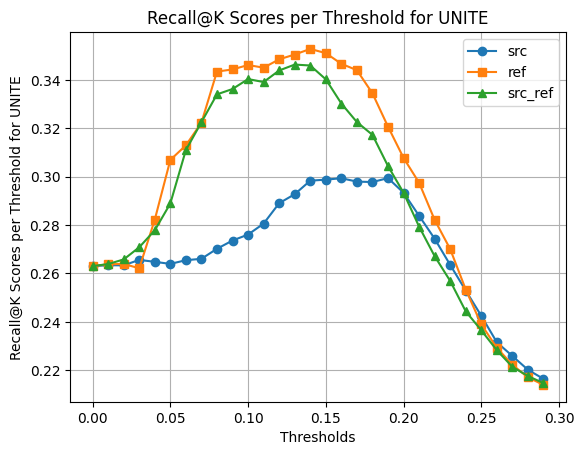

In [ ]:
# skip all sentences with no spans and whole sentence is span
plot([src_f1, ref_f1, src_ref_f1], thresholds, title="Recall@K Scores per Threshold for UNITE")

## Load ACES in MQM format and save the Spans (ACES subword scores from UNITE)

In [ ]:
model_path = "/content/drive/MyDrive/ACES_COMET_baseline/COMET/wmt22-unite-da/checkpoints/model.ckpt"
ACES_data_path_good = "/content/drive/MyDrive/ACES_COMET_baseline/data/ACES_final_merged_MQM_good.csv"
ACES_data_path_incorrect = "/content/drive/MyDrive/ACES_COMET_baseline/data/ACES_final_merged_MQM_incorrect.csv"
output_path_good = "/content/drive/MyDrive/ACES_UNITE_baseline/UNITE_outputs/on_ACES/good"
output_path_incorrect = "/content/drive/MyDrive/ACES_UNITE_baseline/UNITE_outputs/on_ACES/incorrect"

In [ ]:
! python explainable-metrics/save_unite_alignments.py -m {model_path} -t {ACES_data_path_good} --batch_size 8 -o {output_path_good}

2023-11-03 11:50:14.623086: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 11:50:14.623167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 11:50:14.623210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 11:50:16.357860: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file wmt22-unite-da/checkpoints/model.ckpt`
Enc

In [ ]:
! python explainable-metrics/save_unite_alignments.py -m {model_path} -t {ACES_data_path_incorrect} --batch_size 4 -o {output_path_incorrect}

2023-11-03 12:11:25.291388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 12:11:25.291447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 12:11:25.291492: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 12:11:26.547581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file wmt22-unite-da/checkpoints/model.ckpt`
Enc

## Save UNITE spans on ACES

In [ ]:
model_path = "/content/drive/MyDrive/ACES_COMET_baseline/COMET/wmt22-unite-da/checkpoints/model.ckpt"
ACES_data_path_good = "/content/drive/MyDrive/ACES_COMET_baseline/data/ACES_final_merged_MQM_good.csv"
ACES_data_path_incorrect = "/content/drive/MyDrive/ACES_COMET_baseline/data/ACES_final_merged_MQM_incorrect.csv"
scores_path_good = "/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs/on_ACES/good"
scores_path_incorrect = "/content/drive/MyDrive/ACES_COMET_baseline/COMET_outputs/on_ACES/incorrect"
dataset_path = "/content/drive/MyDrive/ACES_COMET_baseline/data/merged.tsv"
threshold = 0.14
if "ckpt" in model_path:
    model = load_from_checkpoint(model_path)
else:
    model_path = download_model(model_path)
    model = load_from_checkpoint(model_path)
model.encoder.add_span_tokens("<v>", "</v>")

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file wmt22-unite-da/checkpoints/model.ckpt`


In [ ]:
import pandas as pd
import csv

def read_file(filename: str) -> pd.DataFrame:
    '''
    Read TSV file and return as pandas DataFrame
    '''
    return pd.read_csv(filename, sep='\t', quoting=csv.QUOTE_NONE)

In [ ]:
def add_span_tokens(binary_mask, integer_array, start_token, end_token):
    modified_integer_array = []

    # Handle the case when binary_mask starts with 1
    if binary_mask[0] == 1:
        modified_integer_array.append(start_token)
        modified_integer_array.append(integer_array[0])
    else:
        modified_integer_array.append(integer_array[0])

    for i in range(1, len(binary_mask)):
        if binary_mask[i] != binary_mask[i - 1]:
            if binary_mask[i] == 1:  # Change from 0 to 1
                modified_integer_array.append(start_token)
            else:  # Change from 1 to 0
                modified_integer_array.append(end_token)
            modified_integer_array.append(integer_array[i])
        else:
            modified_integer_array.append(integer_array[i])

    # Handle the case when binary_mask ends with 1
    if binary_mask[-1] == 1:
        modified_integer_array.append(end_token)
    else:
        modified_integer_array.append(integer_array[-1])

    return modified_integer_array

### Generate spans for the good translations

In [ ]:
with open(os.path.join(scores_path_good, "ref_scores.json"), "r") as f:
    ref_scores = json.load(f)
with open(os.path.join(scores_path_good, "src_scores.json"), "r") as f:
    src_scores = json.load(f)
with open(os.path.join(scores_path_good, "mt_scores.json"), "r") as f:
    mt_scores = json.load(f)
with open(os.path.join(scores_path_good, "src_ref_scores.json"), "r") as f:
    src_ref_scores = json.load(f)
gold_span_masks = src_scores["in_span_mask"]
input_ids = src_scores["input_ids"]
start_token = model.encoder.tokenizer.encode("<v>")[1]
end_token = model.encoder.tokenizer.encode("</v>")[1]

# get all the scores without the padded tags
src_scores_sum, ref_scores_sum, src_ref_scores_sum = [], [], []
for i in range(len(gold_span_masks)):
    padding_filter = np.array(gold_span_masks[i])!=-1
    src_scores_sum.append(np.average(np.array(src_scores["scores"][i])[padding_filter]))
    ref_scores_sum.append(np.average(np.array(ref_scores["scores"][i])[padding_filter]))
    src_ref_scores_sum.append(np.average(np.array(src_ref_scores["scores"][i])[padding_filter]))
print("Mean(mean(scores)) for src, ref, src_ref in all the good-translations: ", np.average(src_scores_sum), np.average(ref_scores_sum), np.average(src_ref_scores_sum))

Mean(mean(scores)) for src, ref, src_ref in all the good-translations:  0.10072777709552645 0.03905673761304628 0.034791574799225185


In [ ]:
import argparse, os, sys, json, logging, csv
from tqdm import tqdm
import pandas as pd
import numpy as np
logger = logging.getLogger('logger')
logging.basicConfig(level=logging.INFO)
from comet import download_model, load_from_checkpoint

gold_spans_input_ids = []
src_spans_input_ids = []
ref_spans_input_ids = []
src_ref_spans_input_ids = []

# for all the samples, calculate the input ids of the sentences with the generated spans. also for the gold annotated sentneces
for i in range(len(gold_span_masks)):
    # common in all
    padding_filter = np.array(gold_span_masks[i])!=-1
    input_ids_tmp = np.array(input_ids[i])[padding_filter]
    gold_spans_input_ids.append(add_span_tokens(np.array(gold_span_masks[i])[padding_filter], input_ids_tmp, start_token, end_token))
    # gold_annotated = model.encoder.tokenizer.decode(add_span_tokens(np.array(gold_span_masks[i])[padding_filter], input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only src
    src_scores_tmp = np.array(src_scores["scores"][i])[padding_filter]
    src_span_masks = src_scores_tmp > threshold
    src_spans_input_ids.append(add_span_tokens(src_span_masks, input_ids_tmp, start_token, end_token))
    # src_annotated = model.encoder.tokenizer.decode(add_span_tokens(src_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only ref
    ref_scores_tmp = np.array(ref_scores["scores"][i])[padding_filter]
    ref_span_masks = ref_scores_tmp > threshold
    ref_spans_input_ids.append(add_span_tokens(ref_span_masks, input_ids_tmp, start_token, end_token))
    # ref_annotated = model.encoder.tokenizer.decode(add_span_tokens(ref_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only src-ref
    src_ref_scores_tmp = np.array(src_ref_scores["scores"][i])[padding_filter]
    src_ref_span_masks = src_ref_scores_tmp > threshold
    src_ref_spans_input_ids.append(add_span_tokens(src_ref_span_masks, input_ids_tmp, start_token, end_token))
    # src_ref_annotated = model.encoder.tokenizer.decode(add_span_tokens(src_ref_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    """
    outs = model.encoder.tokenizer.batch_decode([
                                        input_ids[0],
                                        np.array(input_ids[i])[np.array(gold_span_masks[i])==1],
                                        np.array(input_ids[i])[np.array(src_scores["scores"][i])>threshold],
                                        np.array(input_ids[i])[np.array(ref_scores["scores"][i])>threshold],
                                        np.array(input_ids[i])[np.array(src_ref_scores["scores"][i])>threshold],
                                        ],
                                        skip_special_tokens=True)

    print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", outs[1], "\nSRC PRED:\t", outs[2], "\nREF PRED:\t", outs[3], "\nSRC-REF PRED:\t", outs[4])

    print("--------------------------- FULL SPANS ----------------------------------------------------------------")
    print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", gold_annotated, "\nSRC PRED:\t", src_annotated, "\nREF PRED:\t", ref_annotated, "\nSRC-REF PRED:\t", src_ref_annotated)
    """
# decode to get the spans in string form
all_spans_decoded = model.encoder.tokenizer.batch_decode(gold_spans_input_ids+src_spans_input_ids+ref_spans_input_ids+src_ref_spans_input_ids, skip_special_tokens=True)

gold_spans = all_spans_decoded[:len(gold_spans_input_ids)]
src_spans = all_spans_decoded[len(gold_spans_input_ids):2*len(gold_spans_input_ids)]
ref_spans = all_spans_decoded[2*len(gold_spans_input_ids):3*len(gold_spans_input_ids)]
src_ref_spans = all_spans_decoded[3*len(gold_spans_input_ids):4*len(gold_spans_input_ids)]

good_spans = {
    "gold_spans": gold_spans,
    "src_spans": src_spans,
    "ref_spans":ref_spans,
    "src_ref_spans":src_ref_spans
}

### Generate Translations for Incorrect translations

In [ ]:
# -------------------------------------- INCORRECT TRANSLATIONS --------------------------------------------
# load the scores
with open(os.path.join(scores_path_incorrect, "ref_scores.json"), "r") as f:
    ref_scores = json.load(f)
with open(os.path.join(scores_path_incorrect, "src_scores.json"), "r") as f:
    src_scores = json.load(f)
with open(os.path.join(scores_path_incorrect, "mt_scores.json"), "r") as f:
    mt_scores = json.load(f)
with open(os.path.join(scores_path_incorrect, "src_ref_scores.json"), "r") as f:
    src_ref_scores = json.load(f)
gold_span_masks = src_scores["in_span_mask"]
input_ids = src_scores["input_ids"]
start_token = model.encoder.tokenizer.encode("<v>")[1]
end_token = model.encoder.tokenizer.encode("</v>")[1]

# get all the scores without the padded tags
src_scores_sum, ref_scores_sum, src_ref_scores_sum = [], [], []
for i in range(len(gold_span_masks)):
    padding_filter = np.array(gold_span_masks[i])!=-1
    src_scores_sum.append(np.average(np.array(src_scores["scores"][i])[padding_filter]))
    ref_scores_sum.append(np.average(np.array(ref_scores["scores"][i])[padding_filter]))
    src_ref_scores_sum.append(np.average(np.array(src_ref_scores["scores"][i])[padding_filter]))
print("Mean(mean(scores)) for src, ref, src_ref in all the incorrect-translations: ", np.average(src_scores_sum), np.average(ref_scores_sum), np.average(src_ref_scores_sum))

Mean(mean(scores)) for src, ref, src_ref in all the incorrect-translations:  0.10404583908735113 0.04593183396591655 0.03921985441667195


In [ ]:
gold_spans_input_ids = []
src_spans_input_ids = []
ref_spans_input_ids = []
src_ref_spans_input_ids = []

# for all the samples, calculate the input ids of the sentences with the generated spans. also for the gold annotated sentneces
for i in range(len(gold_span_masks)):
    # common in all
    padding_filter = np.array(gold_span_masks[i])!=-1
    input_ids_tmp = np.array(input_ids[i])[padding_filter]
    gold_spans_input_ids.append(add_span_tokens(np.array(gold_span_masks[i])[padding_filter], input_ids_tmp, start_token, end_token))
    # gold_annotated = model.encoder.tokenizer.decode(add_span_tokens(np.array(gold_span_masks[i])[padding_filter], input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only src
    src_scores_tmp = np.array(src_scores["scores"][i])[padding_filter]
    src_span_masks = src_scores_tmp > threshold
    src_spans_input_ids.append(add_span_tokens(src_span_masks, input_ids_tmp, start_token, end_token))
    # src_annotated = model.encoder.tokenizer.decode(add_span_tokens(src_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only ref
    ref_scores_tmp = np.array(ref_scores["scores"][i])[padding_filter]
    ref_span_masks = ref_scores_tmp > threshold
    ref_spans_input_ids.append(add_span_tokens(ref_span_masks, input_ids_tmp, start_token, end_token))
    # ref_annotated = model.encoder.tokenizer.decode(add_span_tokens(ref_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    # only src-ref
    src_ref_scores_tmp = np.array(src_ref_scores["scores"][i])[padding_filter]
    src_ref_span_masks = src_ref_scores_tmp > threshold
    src_ref_spans_input_ids.append(add_span_tokens(src_ref_span_masks, input_ids_tmp, start_token, end_token))
    # src_ref_annotated = model.encoder.tokenizer.decode(add_span_tokens(src_ref_span_masks, input_ids_tmp, start_token, end_token), skip_special_tokens=True)

    """
    outs = model.encoder.tokenizer.batch_decode([
                                        input_ids[0],
                                        np.array(input_ids[i])[np.array(gold_span_masks[i])==1],
                                        np.array(input_ids[i])[np.array(src_scores["scores"][i])>threshold],
                                        np.array(input_ids[i])[np.array(ref_scores["scores"][i])>threshold],
                                        np.array(input_ids[i])[np.array(src_ref_scores["scores"][i])>threshold],
                                        ],
                                        skip_special_tokens=True)

    print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", outs[1], "\nSRC PRED:\t", outs[2], "\nREF PRED:\t", outs[3], "\nSRC-REF PRED:\t", outs[4])

    print("--------------------------- FULL SPANS ----------------------------------------------------------------")
    print("MT:\t\t", outs[0], "\nGOLD SPAN:\t", gold_annotated, "\nSRC PRED:\t", src_annotated, "\nREF PRED:\t", ref_annotated, "\nSRC-REF PRED:\t", src_ref_annotated)
    """
# decode to get the spans in string form
all_spans_decoded = model.encoder.tokenizer.batch_decode(gold_spans_input_ids+src_spans_input_ids+ref_spans_input_ids+src_ref_spans_input_ids, skip_special_tokens=True)

gold_spans = all_spans_decoded[:len(gold_spans_input_ids)]
src_spans = all_spans_decoded[len(gold_spans_input_ids):2*len(gold_spans_input_ids)]
ref_spans = all_spans_decoded[2*len(gold_spans_input_ids):3*len(gold_spans_input_ids)]
src_ref_spans = all_spans_decoded[3*len(gold_spans_input_ids):4*len(gold_spans_input_ids)]

incorrect_spans = {
    "gold_spans": gold_spans,
    "src_spans": src_spans,
    "ref_spans":ref_spans,
    "src_ref_spans":src_ref_spans
}

### Save The spans

In [ ]:
# ---------------------------------------------- SAVING THE SPANS -----------------------------------------------------
# Save Everything in TSV (similar to merged.tsv).
""" The output format:

"""

# read merged.tsv
content = read_file(dataset_path)
# the columns in merged.tsv: ['ID', 'source', 'good-translation', 'incorrect-translation', 'reference',  'phenomena', 'langpair', 'incorrect-translation-annotated', 'annotation-method']
content = content.reset_index()  # make sure indexes pair with number of rows

# assume the predicted spans are still ordered acc to id?
samples = {}
for index, row in content.iterrows():
    idx = int(row["ID"])
    samples[idx] = {
        'source':row['source'],
        'good-translation':row['good-translation'],
        'incorrect-translation':row['incorrect-translation'],
        'reference':row['reference'],
        'phenomena':row['phenomena'],
        'langpair':row['langpair'],
        'incorrect-translation-annotated-goldtruth':row['incorrect-translation-annotated'],
        "annotation-method":row['annotation-method'],
        'good-translation-predicted-span-src':good_spans["src_spans"][index],
        'good-translation-predicted-span-ref':good_spans["ref_spans"][index],
        'good-translation-predicted-span-src-ref':good_spans["src_ref_spans"][index],
        'incorrect-translation-predicted-span-src':incorrect_spans["src_spans"][index],
        'incorrect-translation-predicted-span-ref':incorrect_spans["ref_spans"][index],
        'incorrect-translation-predicted-span-src-ref':incorrect_spans["src_ref_spans"][index],
    }


In [ ]:
df = pd.DataFrame.from_dict(samples, orient='index', columns=['source', 'good-translation', 'incorrect-translation',
    'reference',  'phenomena', 'langpair', 'incorrect-translation-annotated-goldtruth', 'annotation-method',
    'good-translation-predicted-span-src', 'good-translation-predicted-span-ref', 'good-translation-predicted-span-src-ref',
    'incorrect-translation-predicted-span-src', 'incorrect-translation-predicted-span-ref', 'incorrect-translation-predicted-span-src-ref'])
df.index.name = 'ID'

df.sort_index().to_csv(f'/content/drive/MyDrive/ACES_UNITE_baseline/UNITE_outputs/ACES_predictions_{threshold}.tsv', sep='\t', index=True, quoting=csv.QUOTE_NONE)

In [ ]:
df.sort_index()

,source,good-translation,incorrect-translation,reference,phenomena,langpair,incorrect-translation-annotated-goldtruth,annotation-method,good-translation-predicted-span-src,good-translation-predicted-span-ref,good-translation-predicted-span-src-ref,incorrect-translation-predicted-span-src,incorrect-translation-predicted-span-ref,incorrect-translation-predicted-span-src-ref
ID,,,,,,,,,,,,,,
0,Proper nutritional practices alone cannot gene...,Las prácticas nutricionales adecuadas por sí s...,Las prácticas nutricionales adecuadas por sí s...,No es posible que las prácticas nutricionales ...,addition,en-es,Las prácticas nutricionales adecuadas por sí s...,annotate_word,Las prácticas nutricionales<v> adecuada</v>s<v...,Las prácticas nutricionales adecuadas por sí s...,Las prácticas nutricionales adecuadas por sí s...,Las prácticas nutricionales<v> adecuada</v>s<v...,Las prácticas nutricionales adecuadas por sí s...,Las prácticas nutricionales adecuadas por sí s...
1,"has geographic variations, where the age limi...","tiene variaciones geográficas, donde el límite...","La definición tiene variaciones geográficas, d...","varía geográficamente, donde el límite de eda...",addition,en-es,<v>La definición</v> tiene variaciones geográf...,annotate_word,"tiene variaciones geográficas, donde el límite...","tiene variaciones geográficas, donde el límite...","tiene variaciones geográficas, donde el límite...",La<v> definición</v> tiene variaciones geográf...,La<v> definición</v> tiene variaciones geográf...,La<v> definición</v> tiene variaciones geográf...
2,The U.N. also hopes to finalize a fund to help...,La ONU también espera finalizar un fondo para ...,La ONU también espera finalizar un fondo para ...,La ONU tiene la intención de completar un fond...,addition,en-es,La ONU también espera finalizar un fondo para ...,annotate_word,La ONU también espera finalizar un fondo para ...,La ONU también espera finalizar un fondo para ...,La ONU también espera finalizar un fondo para ...,La ONU también espera finalizar un fondo para ...,La ONU también espera finalizar un fondo para ...,La ONU también espera finalizar un fondo para ...
3,Several million vials of vaccine have also bee...,Varios millones de frascos de vacuna también h...,Varios millones de frascos de vacuna contra la...,Las autoridades también han garantizado varios...,addition,en-es,Varios millones de frascos de vacuna <v>contra...,annotate_word,Varios millones<v> de fra</v>scos de vacuna ta...,Varios millones de<v> fra</v>scos de vacuna ta...,Varios millones de<v> fra</v>scos de vacuna ta...,Varios millones<v> de fra</v>scos de vacuna<v>...,Varios millones de<v> fra</v>scos de vacuna<v>...,Varios millones de<v> fra</v>scos de vacuna<v>...
4,Pre-operative people should not expect to pass...,Las personas preoperativas no deben esperar pa...,Las personas transgénero preoperativas no debe...,Las personas que aún no se han operado no debe...,addition,en-es,Las personas <v>transgénero</v> preoperativas ...,annotate_word,Las personas preoperativas no deben esperar pa...,Las personas<v> preoperativ</v>as no deben esp...,Las personas preoperativas no deben esperar pa...,Las personas<v> transgénero</v> preoperativas ...,Las personas<v> transgénero pre</v>operativas ...,Las personas<v> transgénero</v> preoperativas ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36471,Sullivan ใช้มนต์แห่งความเท่าเทียมหลังที่เขาตระ...,Sullivan used the mantra of equality after he ...,Sullivan invokes the mantra of equal treatment...,Sullivan uses the mantra of equal treatment af...,xnli-omission-neutral,th-en,<v>Sullivan invokes the mantra of equal treatm...,whole_sentence - duplicate of: 3702,Sullivan used<v> the mantra</v> of e<v>quality...,Sullivan used the mantra of equality after he ...,Sullivan used the mantra of equality after he ...,Sullivan<v> invokes the mantra of equal treatm...,Sullivan in<v>vok</v>es the mantra of equal tr...,Sullivan in<v>vok</v>es the mantra of equal tr...
36472,ในฐาน

In [ ]:
threshold

0.14